### CONCERNS
1. list of directions/positions are never emptied during an episode, which makes the simulation slower and slower after each timestep

### IDEAS
other possible features:
1. robot is fallen down or not
2. distance to border (& which border?)

time optimalization:
1. clear last item from history every 4 timesteps (we only use the current and previous state and the one before that)
2. interval of states to be interpreted: skip N frames before evaluation next state
3. Since the rewards are so sparse, maybe use Imitation learning instead of DQN --> we are "experts" since we know the tactic of the blue bot. we can use this to teach our bot how to defeat the other agent.
4. rewrite the random action function 

In [1]:
from VisualModule import AgentEnvironment
from DQN_Agent import NeurosmashAgent

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize

import gym
import math
import random
from collections import namedtuple
from itertools import count
from PIL import Image
import os

from stopwatch import Stopwatch


Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model_output_dir = "output/model_output/"

if not os.path.exists(model_output_dir):
    os.makedirs(model_output_dir)

max_distance = 600
show_images = False
skip_frames = 15
state_size =  13 # agent_pos, enemy_pos, vec_agent, vec_enemy, rel_pos_enemy, done
action_size = 3
episode_count = 1000
batch_size = 32
size       = 768         # Please check the Updates section above for more details
timescale  = 10           # Please check the Updates section above for more details

In [5]:
environment = AgentEnvironment(size=size, timescale=timescale)
agent = NeurosmashAgent(state_size = state_size, action_size = action_size) # action size: move in x or y direction, or do nothing

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
def compute_reward(standard_reward, distance):
    distance_reward = (max_distance-distance)/max_distance
    total_reward = (distance_reward + standard_reward)/ 2
    return total_reward

In [7]:
def direction(agent_path, enemy_path):
    A_X = (agent_path[-1] - np.array(agent_path[-2]))[0]
    A_Y = -(agent_path[-1] - np.array(agent_path[-2]))[1]
    E_X = (enemy_path[-1] - np.array(enemy_path[-2]))[0]
    E_Y = -(enemy_path[-1] - np.array(enemy_path[-2]))[1]
    return [A_X,A_Y],[E_X,E_Y]

def do_action(action, total_steps, eval_pic):
    stopwatch = Stopwatch() 
    stopwatch.start()
    # Normalize the values 
    info, reward, agent_coord, enemy_coord, _ = environment.actionLoop(action, 0, 1)
    # Replace folowing_state with the representation

    
    stopwatch.stop()
    #print(f"Total time for do action: {stopwatch.duration}")
    if len(environment.agent_path) < 2:
        distance = 500 # Initial distance, only for initialisation
        agent_direction = [1,0] # By definition of facing each other
        enemy_direction = [-1,0]
        
    else:
        distance = np.sqrt(np.square(np.array(list(np.array(agent_coord)- np.array(enemy_coord))).sum(axis=0)))
        # Extract all variables 
        agent_direction, enemy_direction  = direction(environment.agent_path, environment.enemy_path)
    
    complete_reward = compute_reward(reward, distance)

    rel_pos_enemy = np.array(enemy_coord) - np.array(agent_coord)
    # Return a value in range 0,1 for following_state
    # Nstatus = d[0]
    # Ncomplete_reward = d[1]
    # Nagent_posx = d[2][0]/700
    # Nagent_posy = d[2][1]/700
    # Nenemy_posx = d[3][0]/700
    # Nenemy_posy = d[3][1]/700
    # Nagent_dirx = d[4][0]/60+0.5
    # Nagent_diry = d[4][1]/60+0.5
    # Nenemy_dirx = d[5][0]/60+0.5
    # Nenemy_diry = d[5][1]/60+0.5
    # Nenemy_pos_relx = d[7][0]/1400+0.5
    # Nenemy_pos_rely = d[7][1]/1400+0.5
    # Ndistance = d[6]/700
   
    d=info, complete_reward, np.array(agent_coord), np.array(enemy_coord), agent_direction, enemy_direction, distance, rel_pos_enemy
    following_state = d[0],d[1],d[2][0]/700,d[2][1]/700,d[3][0]/700,d[3][1]/700,\
     d[4][0]/60+0.5,d[4][1]/60+0.5,d[5][0]/60+0.5,d[5][1]/60+0.5,\
     d[7][0]/1400+0.5,d[7][1]/1400+0.5,d[6]/700
    
    return list(following_state)

In [8]:
def init_environment(env, agent_here):
    info, reward, state = env.reset() 
    agent_trajectories = []
    enemy_trajectories = []
    
    small_init_state = [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], False]
    
    #for i in range(3):
    action = agent_here.act(small_init_state) # get next action
    # action = 3 (if above does not work)
    
    #pre_state_img = np.flip(np.array(state).reshape(3,256,256).transpose(1,2,0),0)
    #step_number_now = i+1
    info, complete_reward, agent_pos, enemy_pos, agent_direction, enemy_direction, distance, relative_pos_enemy, next_state = do_action(action, 1, True)  
    
    #post_state_img = np.flip(np.array(next_state).reshape(3,256,256).transpose(1,2,0),0)

    #agent_pos, enemy_pos = env_feat.coord(pre_state_img, post_state_img)
    agent_trajectories.append(list(agent_pos))
    enemy_trajectories.append(list(enemy_pos))
        
    return 

# Experiment 

In [9]:
from sklearn.neural_network import MLPRegressor
import numpy as np
import pickle
# load the model from disk

nn = pickle.load(open("model.sav", 'rb'))
#nn = MLPRegressor(
     # hidden_layer_sizes=(100,100,100,100),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
     # learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
     # random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
     # early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


In [10]:
### Train the model with 
NumberOfGames=1
epsilon = 0.6 # zero means model, 1 random.

Game number and reward 1 loose


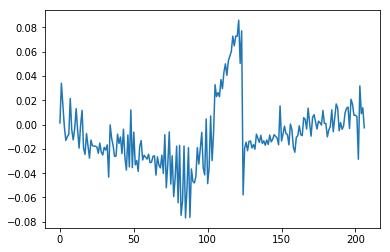

In [14]:
u=0
for i in range(NumberOfGames):
    environment.reset() 
    F_next_state=[]
    F_reward=[]
    u+=1
    j=1
    status=0
    
    rand=True
    while status==0 or j<10:  
        if np.random.rand() <= epsilon:
            rand=True
        else:
            rand=False
            
        
        if rand:
            action=random.randrange(3)



        next_state = do_action(action,1,True)
        # action=NewAgent.act(1)

        status=next_state[0] # Normalized status 
        reward=next_state[1] # reward
        next_state = next_state[2:] # State variables
        next_state.append(action/2)

        F_next_state.append(next_state)
        F_reward.append(reward)
        exp_value=[]
        if rand:
                action=random.randrange(3)
        else:
            for k in range(3):
                ex_reward=F_next_state[-1][:-1]
                ex_reward.append(k/2)
                ex_reward
                prediction=nn.predict(np.array(ex_reward).reshape(1, -1))
                exp_value.append(prediction)
            action = np.argmax(exp_value)
        
        j=10
        
    x = F_next_state
    y = F_reward
    n = nn.fit(x, y) # Train after each game
    filename = 'model.sav'
    pickle.dump(nn, open(filename, 'wb'))
    print("Game number and reward",u,["loose","win","win","win","win","win"][int(y[-1])])
    plt.plot(nn.predict(F_next_state)-F_reward)

'win'